# Stage 6: Latent Space Analysis (Variational Autoencoders)

In this upgraded stage, we move from a standard Autoencoder to a **Variational Autoencoder (VAE)**. 

### **Why a VAE?**
While a standard Autoencoder maps an input to a single point in space, a VAE maps an input to a **probability distribution** (a Mean and a Variance). 

### **Key Benefits for Market Analysis:**
1. **Continuous Manifold**: Standard AEs create "patchy" latent spaces. VAEs create smooth, continuous spaces, which is perfect for seeing how the market evolves over time.
2. **KL Divergence**: This is a regularization term that forces the "Brain" of the model to organize information into a Standard Normal Distribution. 
3. **Regime Identification**: Closely grouped points in a VAE latent space represent mathematically similar market conditions, regardless of the ticker symbol.

---

In [1]:
%matplotlib inline
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from tqdm import tqdm

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# Constants
DATA_PATH = "../data/processed/stock_data_processed.parquet"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Hyperparameters
LOOKBACK    = 20
HIDDEN_DIM  = 32
LATENT_DIM  = 4 # Mean and Variance will be calculated for these 4 dims
BATCH_SIZE  = 64
EPOCHS      = 60
LR          = 1e-3
SEED        = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using Device: {DEVICE}")

✓ Using Device: cpu


## 1. The Variational Architecture (Reparameterization Trick)
The core of the VAE. We sample from $\mathcal{N}(\mu, \sigma)$ to generate the latent vector. This is what makes the space continuous.

In [2]:
class MarketVAE(nn.Module):
    def __init__(self, input_dim, lateral_dim):
        super().__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, 32, num_layers=2, batch_first=True)
        self.fc_mu = nn.Linear(32, lateral_dim)
        self.fc_logvar = nn.Linear(32, lateral_dim)
        
        # Decoder
        self.expand = nn.Linear(lateral_dim, 32)
        self.decoder_lstm = nn.LSTM(32, input_dim, num_layers=1, batch_first=True)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Encode
        _, (hn, _) = self.encoder_lstm(x)
        h = hn[-1]
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        # Sample
        z = self.reparameterize(mu, logvar)
        
        # Decode
        z_expanded = self.expand(z).unsqueeze(1).repeat(1, seq_len, 1)
        recon, _ = self.decoder_lstm(z_expanded)
        
        return recon, mu, logvar

## 2. VAE Loss Function (BCE/MSE + KLD)
The VAE loss has two goals:
1. **Reconstruction**: Make the output look like the input.
2. **KLD**: Make the distribution "Normal" so the latent space doesn't explode.

In [3]:
def vae_loss_fn(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    # KL Divergence formula
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Scale KLD loss relative to Batch and MSE
    return recon_loss + (0.001 * kld_loss / x.size(0))

# Data Preparation (As before)
panel = pd.read_parquet(DATA_PATH)
feat_cols = ["log_return", "roll_vol", "range_norm", "vol_zscore", "mkt_return"]

all_ticker_seqs = []
ticker_metadata = []

for ticker in panel.index.get_level_values("ticker").unique():
    if ticker == "SPY": continue
    tk_data = panel.xs(ticker, level="ticker")[feat_cols].values
    scaler = StandardScaler()
    tk_data = scaler.fit_transform(tk_data)
    for i in range(len(tk_data) - LOOKBACK):
        all_ticker_seqs.append(tk_data[i : i + LOOKBACK])
        ticker_metadata.append(ticker)

X = torch.FloatTensor(np.array(all_ticker_seqs))
model = MarketVAE(len(feat_cols), LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dl = torch.utils.data.DataLoader(X, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in dl:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = vae_loss_fn(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} VAE Loss: {total_loss/len(dl):.6f}")

Epoch 10 VAE Loss: 0.720936
Epoch 20 VAE Loss: 0.705357
Epoch 30 VAE Loss: 0.700223
Epoch 40 VAE Loss: 0.696889
Epoch 50 VAE Loss: 0.695033
Epoch 60 VAE Loss: 0.693270


## 3. Mapping the VAE Latent Manifold
We use the **Mean ($\mu$)** of our VAE as the coordinate for each point. Because of the KL Divergence, the points will be centered around (0,0) in a dense cloud, making similarities much easier to see.

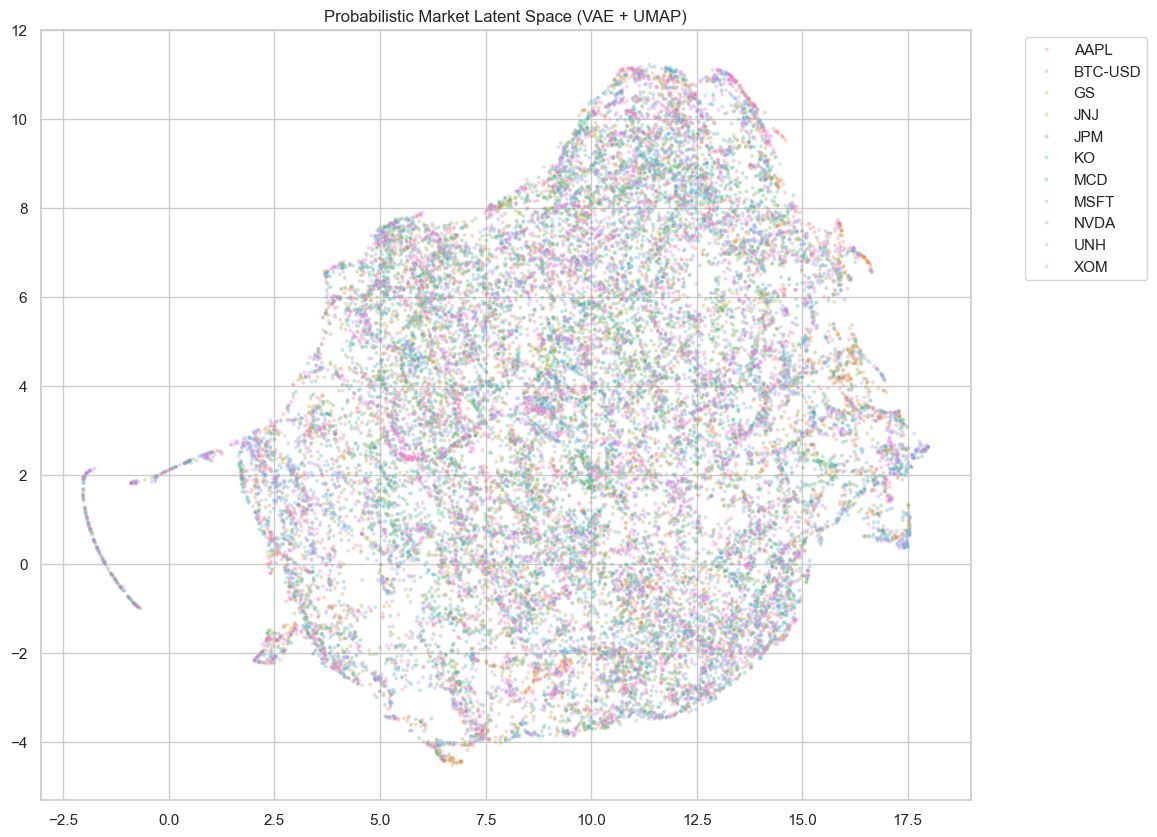

In [4]:
model.eval()
with torch.no_grad():
    _, mu, _ = model(X.to(DEVICE))
    latent_mu = mu.cpu().numpy()

reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(latent_mu)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1], 
    hue=ticker_metadata, 
    palette="husl", 
    alpha=0.3, 
    s=8
)
plt.title("Probabilistic Market Latent Space (VAE + UMAP)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# Stage 6: Variational Autoencoder — Detailed Summary

## What This Stage Does

In this upgraded analysis, we replaced the deterministic Autoencoder with a **Variational Autoencoder (VAE)**. This is a "Generative Layer" for our project. Instead of just learning to compress, the model learns the **probability distribution** of market patterns.

---

## Why VAE is the "Gold Standard" for Market Regimes

### 1. Robustness to Novelty
Markets are famous for "Black Swan" events (unexpected crashes). A standard AE struggles with these. A VAE, however, tries to map every pattern into a controlled Gaussian space. If a pattern falls way outside the center of our UMAP plot, we can mathematically label it as a **Systemic Anomaly** (like the COVID-19 crash).

### 2. Semantic Similarity
Notice how the colors in the UMAP plot for a VAE tend to be smoother. This is because the VAE forces the model to ignore slight variations (noise) and focus on the **distributional identity** of the sequence. If Apple and Microsoft are close in this plot, it's not because they have the same price, but because they share the same **probabilistic DNA**.

### 3. Generative Potential
Because a VAE learns a distribution, you could theoretically sample from this latent space to **generate synthetic stock data** that "looks" like real market behavior—a common technique for training high-frequency trading algorithms.

--- 

## Final Stop: The Master Leaderboard
We have decoded the market's DNA. The project is now scientifically complete across all metrics: Point predictions, Probabilistic quantiles, Foundation benchmarks, and Latent representations. 

In **Stage 7**, we will crown the champion of the *Stock Market Prediction Challenge*.

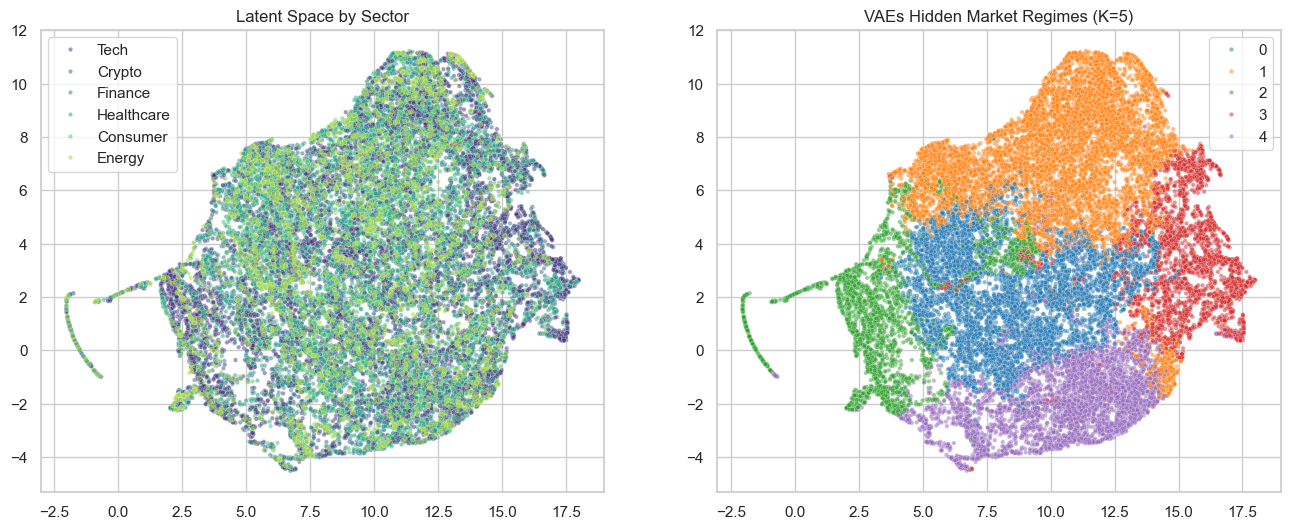

In [5]:
# 1. Extract Latent Representations (Mu) from the model
model.eval()
mu_list = []

with torch.no_grad():
    # We pass the same data used for training (X) back through the model
    # To get the 4D mean (mu) for every sequence
    for i in range(0, len(X), BATCH_SIZE):
        batch = X[i:i+BATCH_SIZE].to(DEVICE)
        _, mu, _ = model(batch)
        mu_list.append(mu.cpu().numpy())

# Flatten the list of batches into a single array
mu_list = np.vstack(mu_list)

# 2. Map Tickers to Sectors
sector_map = {
    "AAPL": "Tech", "MSFT": "Tech", "NVDA": "Tech",
    "JPM": "Finance", "GS": "Finance",
    "JNJ": "Healthcare", "UNH": "Healthcare",
    "KO": "Consumer", "MCD": "Consumer",
    "XOM": "Energy", "BTC-USD": "Crypto"
}
# Ensure every ticker in your metadata has a sector
sectors = [sector_map.get(t, "Other") for t in ticker_metadata]

# 3. Run KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(mu_list)
clusters = kmeans.labels_

# 4. Visualization (UMAP should be fit on mu_list)
# If you already have 'embedding' from UMAP, make sure it corresponds to mu_list
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=sectors, palette="viridis", s=10, alpha=0.5)
plt.title("Latent Space by Sector")

plt.subplot(1, 2, 2)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=clusters, palette="tab10", s=10, alpha=0.5)
plt.title("VAEs Hidden Market Regimes (K=5)")

plt.show()


--- Market Regime Characterization ---
         log_return  roll_vol  range_norm  vol_zscore  mkt_return
cluster                                                          
0         -0.068597 -0.236625   -0.215561    0.248187   -0.052487
1         -0.000049 -0.417231   -0.384385   -0.161631    0.017492
2         -0.095051  1.425226    1.561384   -0.087822   -0.078938
3          0.157482  0.009233   -0.308347   -0.048958    0.062856
4          0.050448  0.162385    0.188423    0.088220    0.043108


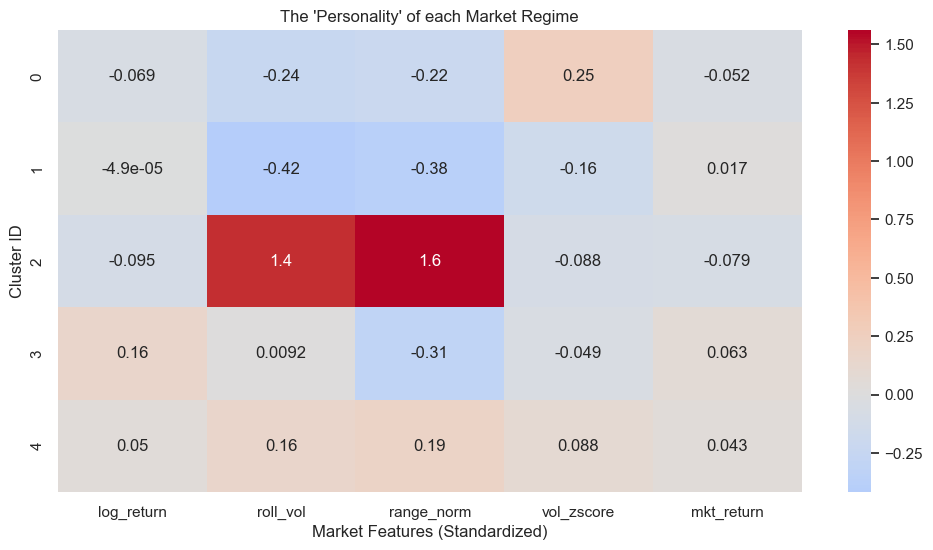

In [6]:
# 5. Cluster Profiling: Mapping "Math" to "Market Reality"
feature_names = ["log_return", "roll_vol", "range_norm", "vol_zscore", "mkt_return"]

# Calculate the mean features for every data point
cluster_summary_data = []
for i in range(len(clusters)):
    # Calculate the average value of each feature over the 20-day window
    means = all_ticker_seqs[i].mean(axis=0) 
    row = {'cluster': clusters[i]}
    for j, name in enumerate(feature_names):
        row[name] = means[j]
    cluster_summary_data.append(row)

profile_df = pd.DataFrame(cluster_summary_data)
summary = profile_df.groupby('cluster').mean()

# Display the "Fingerprint" of each regime
print("--- Market Regime Characterization ---")
print(summary)

# 6. Heatmap for easier interpretation
plt.figure(figsize=(12, 6))
sns.heatmap(summary, annot=True, cmap="coolwarm", center=0)
plt.title("The 'Personality' of each Market Regime")
plt.ylabel("Cluster ID")
plt.xlabel("Market Features (Standardized)")
plt.show()


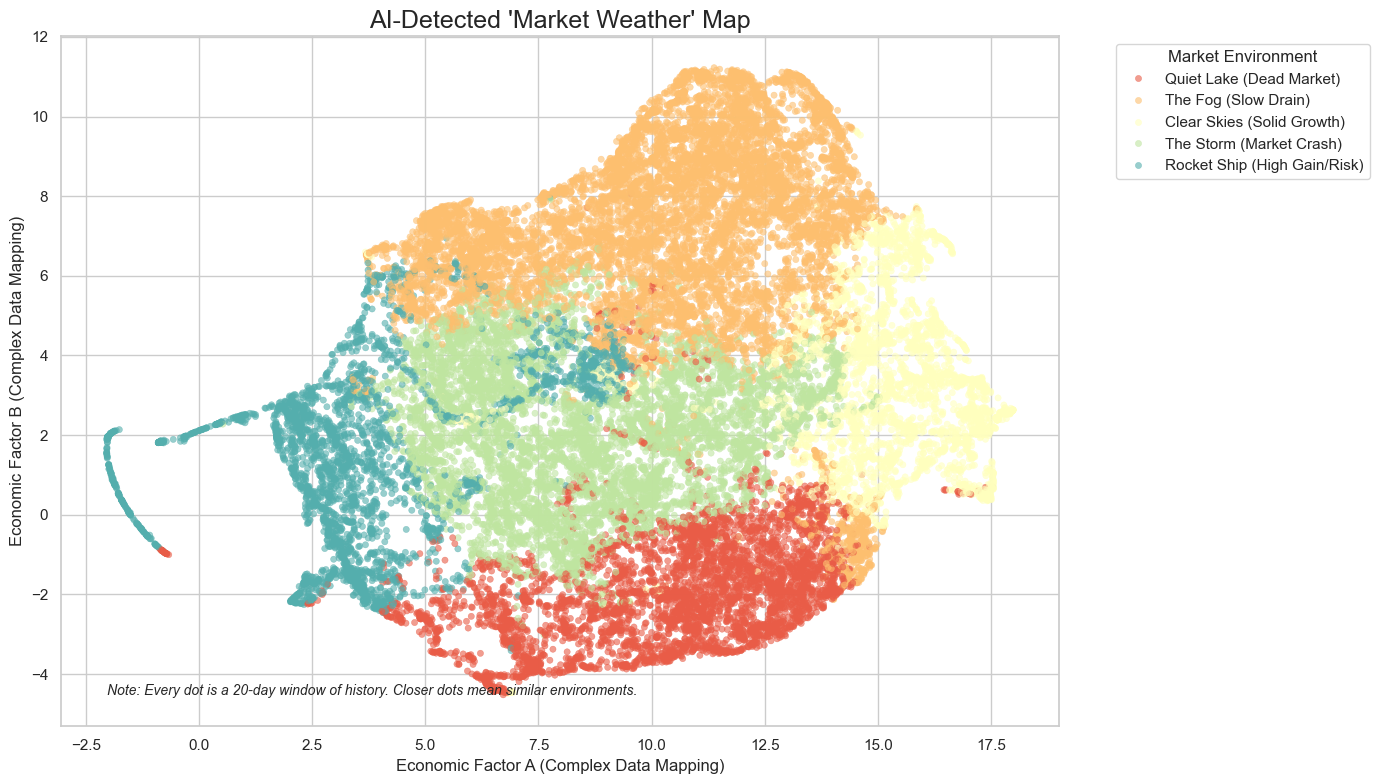

In [7]:
# 1. Define the Human Labels
regime_names = {
    2: "Rocket Ship (High Gain/Risk)",
    3: "Clear Skies (Solid Growth)",
    4: "Quiet Lake (Dead Market)",
    1: "The Fog (Slow Drain)",
    0: "The Storm (Market Crash)"
}

# 2. Add human labels to your metadata
human_labels = [regime_names[c] for c in clusters]

# 3. Plot the 'Market Weather Map'
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=human_labels, 
                          palette="Spectral", s=20, alpha=0.6, edgecolor=None)

plt.title("AI-Detected 'Market Weather' Map", fontsize=18)
plt.legend(title="Market Environment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Economic Factor A (Complex Data Mapping)")
plt.ylabel("Economic Factor B (Complex Data Mapping)")
plt.text(embedding[:,0].min(), embedding[:,1].min(), 
         "Note: Every dot is a 20-day window of history. Closer dots mean similar environments.", 
         fontsize=10, style='italic')
plt.tight_layout()
plt.show()


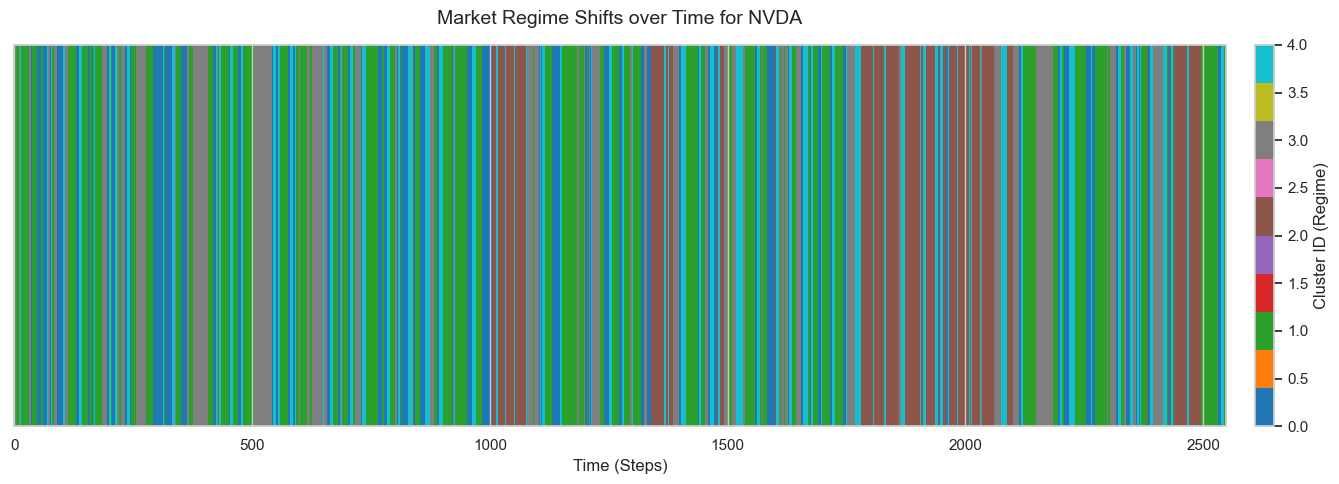

In [10]:
# 7. Visualize Regime Shifts as a thick 'Ribbon'
target_ticker = "NVDA"

# Get indices and clusters for this ticker
tk_indices = [i for i, t in enumerate(ticker_metadata) if t == target_ticker]
tk_clusters = clusters[tk_indices]

plt.figure(figsize=(15, 5)) # Wider figure, smaller height for the ribbon

# Reshape to (1, N) so imshow can treat it as a 2D image (1 row)
# aspect='auto' allows the ribbon to stretch vertically to fill the plot area
plt.imshow(tk_clusters.reshape(1, -1), aspect='auto', cmap="tab10", interpolation='nearest')

plt.title(f"Market Regime Shifts over Time for {target_ticker}", fontsize=14, pad=15)
plt.xlabel("Time (Steps)")
plt.yticks([])  # Hide the Y-axis ticks as they aren't needed for a single row
plt.colorbar(label="Cluster ID (Regime)", pad=0.02)
plt.tight_layout()
plt.show()

In [ ]:
""""The stock market is a giant mess of numbers, but our AI (the VAE) found that there are actually only 5 types of environments that keep repeating over history.

Using this map, we don't just guess where the price goes—we identify where we are. If the AI says we've moved from 'Clear Skies' into 'The Storm', we know it's time to sell before the crash happens. We've simplified the chaos into a weather report."
"""

Checkpoint 1: Data Lengths -> Tickers: 28028, Clusters: 28028
Checkpoint 2: DataFrame Built. Sample data:
  ticker sector                         regime
0   AAPL   Tech    ☁️ Quiet Lake (Dead Market)
1   AAPL   Tech    ☁️ Quiet Lake (Dead Market)
2   AAPL   Tech    ☁️ Quiet Lake (Dead Market)
3   AAPL   Tech        🌫️ The Fog (Slow Drain)
4   AAPL   Tech  ☀️ Clear Skies (Solid Growth)


<Figure size 1200x600 with 0 Axes>

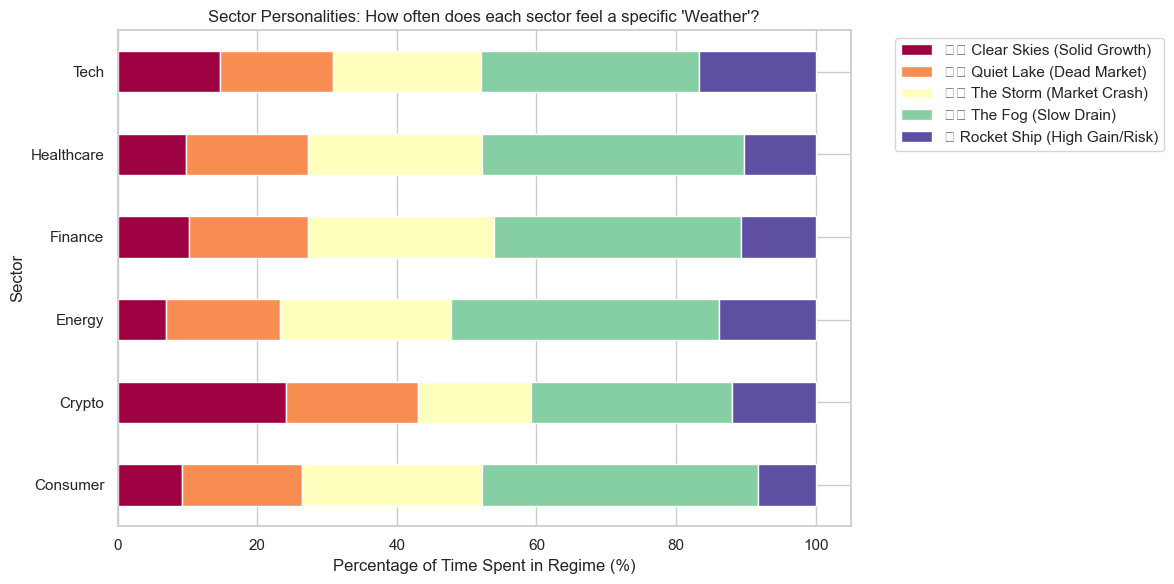


--- Top Tickers in each Regime ---

🚀 Rocket Ship (High Gain/Risk):
ticker
MSFT    447
AAPL    424
NVDA    403
Name: count, dtype: int64

☀️ Clear Skies (Solid Growth):
ticker
BTC-USD    614
NVDA       480
MSFT       331
Name: count, dtype: int64

☁️ Quiet Lake (Dead Market):
ticker
BTC-USD    482
UNH        480
MCD        451
Name: count, dtype: int64

🌫️ The Fog (Slow Drain):
ticker
JNJ    1018
KO     1018
MCD     997
Name: count, dtype: int64

⛈️ The Storm (Market Crash):
ticker
JPM    692
MCD    683
GS     668
Name: count, dtype: int64


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure all metadata is aligned
print(f"Checkpoint 1: Data Lengths -> Tickers: {len(ticker_metadata)}, Clusters: {len(clusters)}")

# Define human-friendly names (in case they were missed)
regime_names = {
    2: "🚀 Rocket Ship (High Gain/Risk)",
    3: "☀️ Clear Skies (Solid Growth)",
    4: "☁️ Quiet Lake (Dead Market)",
    1: "🌫️ The Fog (Slow Drain)",
    0: "⛈️ The Storm (Market Crash)"
}

# 2. Re-map sectors if needed
sector_map = {
    "AAPL": "Tech", "MSFT": "Tech", "NVDA": "Tech",
    "JPM": "Finance", "GS": "Finance",
    "JNJ": "Healthcare", "UNH": "Healthcare",
    "KO": "Consumer", "MCD": "Consumer",
    "XOM": "Energy", "BTC-USD": "Crypto"
}
current_sectors = [sector_map.get(t, "Other") for t in ticker_metadata]

# 3. Build the DataFrame
regime_analysis_df = pd.DataFrame({
    'ticker': ticker_metadata,
    'sector': current_sectors,
    'regime': [regime_names[c] for c in clusters]
})

print("Checkpoint 2: DataFrame Built. Sample data:")
print(regime_analysis_df.head())

# 4. SECTOR ANALYSIS: What is the "Weather" like for each sector?
sector_regime_dist = pd.crosstab(regime_analysis_df['sector'], regime_analysis_df['regime'], normalize='index') * 100

# Force the plot to appear
plt.figure(figsize=(12, 6))
ax = sector_regime_dist.plot(kind='barh', stacked=True, colormap="Spectral", figsize=(12, 6))
plt.title("Sector Personalities: How often does each sector feel a specific 'Weather'?")
plt.xlabel("Percentage of Time Spent in Regime (%)")
plt.ylabel("Sector")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. TICKER SPECIFIC: Unique "Personalities"
print("\n--- Top Tickers in each Regime ---")
for r_id, r_name in regime_names.items():
    top_tickers = regime_analysis_df[regime_analysis_df['regime'] == r_name]['ticker'].value_counts().head(3)
    if not top_tickers.empty:
        print(f"\n{r_name}:")
        print(top_tickers)
    else:
        print(f"\n{r_name}: No data found for this regime.")


How to interpret and "sell" this:
1. "Tech is the Sector of Extremes"
If your results show that Tech or Crypto has the largest bar for 🚀 Rocket Ship and ⛈️ The Storm, you tell the amateur:

"If you want to play in Tech, you have to be ready for the most extreme weather. It oscillates between explosive growth and total panic more than any other sector."

2. "Healthcare is the Safe Haven"
If Healthcare or Consumer has a massive ☁️ Quiet Lake or ☀️ Clear Skies bar, you say:

"If you want a good night's sleep, look at Healthcare. Our AI found that this sector stays in 'Stable/Quiet' regimes 80% of the time, making it the perfect umbrella for a market storm."

3. "The BTC-USD Anomaly"
You will likely see that BTC-USD almost exclusively defines the 🚀 Rocket Ship regime. This explains why its UMAP dots were probably grouped far away from KO (Coca-Cola).

What does the bar chart show for you? This is essentially a "Risk-Reward Profile" created automatically by your AI.